In [51]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spla
import scipy.fft as sfft
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from hw5_helper_funcs import *
try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception as e:
    _HAS_CVXPY = False
    print("Warning: cvxpy not available.")

**Name:** Jack Chou

## Problem 1: Function Recovery: LS, Modified Tikhonov Regularization, ℓ1 Regularization ##

In [55]:
# Parameters
n = 200
m_kernel = 6
sigma = 3.0
psf = gaussian_psf_from_m_sigma(m=m_kernel, sigma=sigma)
print("n =", n)
print("m_kernel =", m_kernel)
print("sigma =", sigma)

A_zero = blur_matrix_zero_boundary(psf, n)
L_I  = identity_matrix(n)
L_D1 = diff_matrix_first(n)
# print("||L*1|| should be ~0:", np.linalg.norm(L_D1 @ np.ones(n)))

n = 200
m_kernel = 6
sigma = 3.0


In [57]:
# Case 1: Sparse Signal
f_sparse_true = signal_sparse(n=n, s=10, scale=1.0)
g_sparse_clean = A_zero @ f_sparse_true
g_sparse_noisy, e_sparse = add_relative_noise(g_sparse_clean, rel=0.05)  # 5% noise


# LS
f_sparse_ls = solve_ls(A_zero, g_sparse_noisy)

# Tikhonov (L = I for sparse)
target_sparse = np.linalg.norm(e_sparse)
lam_disc_sp, f_sparse_tik = pick_lambda_discrepancy_bisect(A_zero, L_I, g_sparse_noisy, target_sparse)
print("λ sparse =", lam_disc_sp)

# ℓ1 (L = I for sparse)
mu_sparse, f_sparse_l1 = pick_mu_discrepancy_bisect(A_zero, L_I, g_sparse_noisy, target_sparse)
print("μ sparse =", mu_sparse)


λ sparse = 0.03292896837493047
μ sparse = 0.001985416206020707


In [59]:
# Case 2: Piecewise-constant (TV prior: L = first difference)
f_pwc_true = signal_piecewise_constant(n=n)
g_pwc_clean = A_zero @ f_pwc_true
g_pwc_noisy, e_pwc = add_relative_noise(g_pwc_clean, rel=0.05)  # 5%

# LS
f_pwc_ls = solve_ls(A_zero, g_pwc_noisy)

# Tikhonov with L = D1 (smoothness penalty on first differences)
target_pwc = np.linalg.norm(e_pwc)
lam_pc_disc, f_pwc_tik = pick_lambda_discrepancy_bisect(A_zero, L_D1, g_pwc_noisy, target_pwc)
print("λ TV=", lam_pc_disc)

# TV / ℓ1 on first differences
mu_tv, f_pwc_tv = pick_mu_discrepancy_bisect(A_zero, L_D1, g_pwc_noisy, target_pwc)
print("μ TV =", mu_tv)

λ TV= 0.49580682416846555
μ TV = 0.40315193628604395


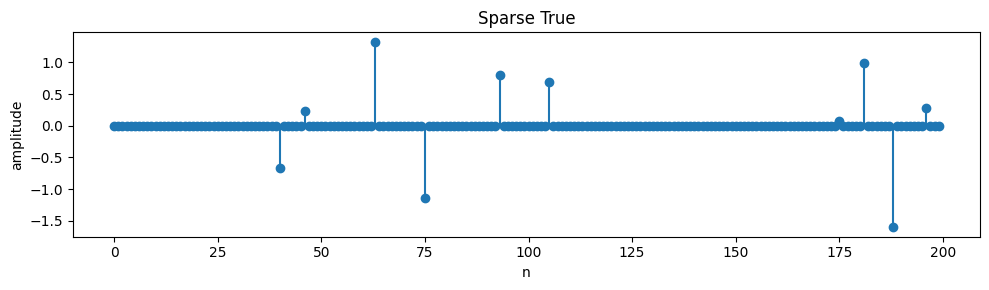

In [61]:
fig, ax = plt.subplots(figsize=(10, 3))
x = np.arange(f_sparse_true.size)
ax.stem(x, f_sparse_true, basefmt=' ')
ax.set_title("Sparse True")
ax.set_xlabel("n")
ax.set_ylabel("amplitude")
plt.tight_layout()
plt.show()

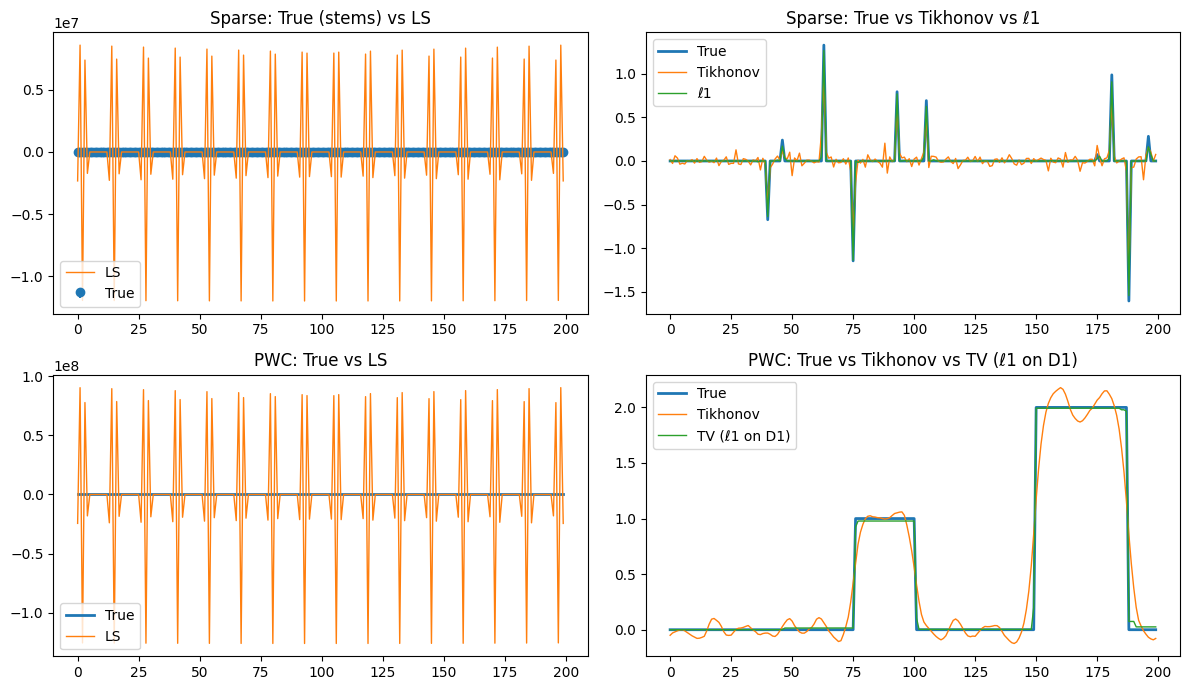

In [63]:
# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

x = np.arange(len(f_sparse_true))

# Sparse: True (stems) vs LS
axes[0].stem(x, f_sparse_true, linefmt='C0-', basefmt=' ', label='True')
axes[0].plot(x, f_sparse_ls, lw=1, label='LS')
axes[0].set_title("Sparse: True (stems) vs LS")
axes[0].legend()

# Sparse: True vs Tikhonov vs ℓ1
axes[1].plot(x, f_sparse_true, lw=2, label='True')
axes[1].plot(x, f_sparse_tik, lw=1, label='Tikhonov')
if _HAS_CVXPY:
    axes[1].plot(x, f_sparse_l1, lw=1, label='ℓ1')
axes[1].set_title("Sparse: True vs Tikhonov vs ℓ1")
axes[1].legend()

# PWC: True vs LS
x2 = np.arange(len(f_pwc_true))
axes[2].plot(x2, f_pwc_true, lw=2, label='True')
axes[2].plot(x2, f_pwc_ls, lw=1, label='LS')
axes[2].set_title("PWC: True vs LS")
axes[2].legend()

# PWC: True vs Tikhonov vs TV
axes[3].plot(x2, f_pwc_true, lw=2, label='True')
axes[3].plot(x2, f_pwc_tik, lw=1, label='Tikhonov')
axes[3].plot(x2, f_pwc_tv, lw=1, label='TV (ℓ1 on D1)')
axes[3].set_title("PWC: True vs Tikhonov vs TV (ℓ1 on D1)")
axes[3].legend()

plt.tight_layout()
plt.show()


In [64]:
print("Double Check")

print("Sparse:")
print("  LS rel err:", relerr(f_sparse_ls,  f_sparse_true))
print("  Tik rel err:", relerr(f_sparse_tik, f_sparse_true))
if _HAS_CVXPY: print("  L1 rel err:", relerr(f_sparse_l1,  f_sparse_true))

print("\nPWC:")
print("  LS rel err:", relerr(f_pwc_ls,  f_pwc_true))
print("  Tik rel err:", relerr(f_pwc_tik, f_pwc_true))
if _HAS_CVXPY: print("  TV rel err:", relerr(f_pwc_tv,  f_pwc_true))

# Explains why LS explodes
svals = np.linalg.svd(A_zero, compute_uv=False)
print("\nblur cond(A):", svals[0]/svals[-1], ", smallest σ ≈", svals[-1])

Double Check
Sparse:
  LS rel err: 23197115.70162896
  Tik rel err: 0.3886608267526403
  L1 rel err: 0.0833700658019523

PWC:
  LS rel err: 52776950.370476924
  Tik rel err: 0.19331640032310368
  TV rel err: 0.023960038501548934

blur cond(A): 59498148715.25219 , smallest σ ≈ 1.6779794820581446e-11


**Changes in Noise and Blur**

n=200, tau=1.05
sigma = 3.0
noise_levels =  [0.01, 0.03, 0.05, 0.1]


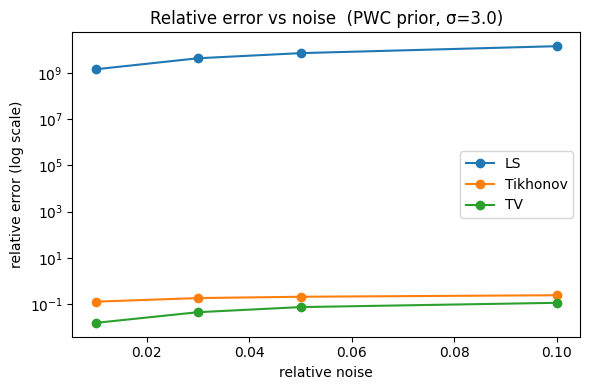

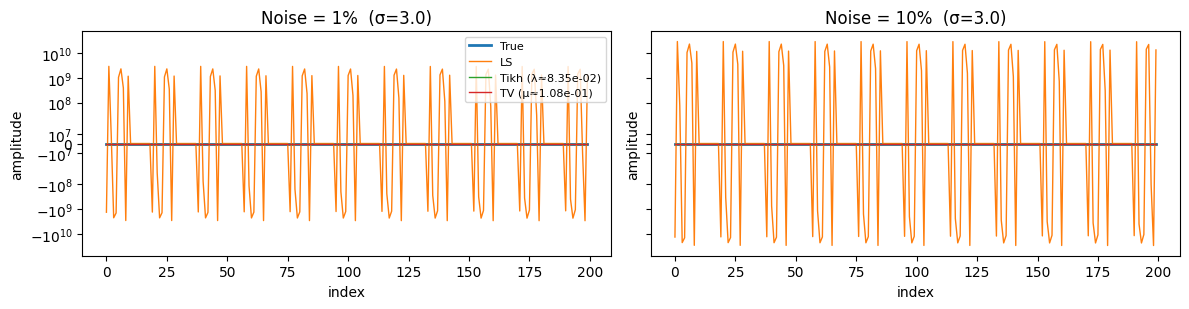

In [96]:
np.random.seed(0)
n = 200
x = np.arange(n)
tau = 1.05
print(f"n={n}, tau={tau}")


# Use PWC truth so TV is the "right" prior (shows edge preservation)
f_true = signal_piecewise_constant(n)
L_D1   = diff_matrix_first(n)

# 1) NOISE SWEEP (fixed blur σ)
sigma_fixed = 3.0
A_fixed = make_A_zero(n, sigma_fixed)
noise_levels = [0.01, 0.03, 0.05, 0.10]
print("sigma =", sigma_fixed)
print("noise_levels = ", noise_levels)

# same noise direction across all levels
eta_dir = None
res_noise = []
for nl in noise_levels:
    r = solve_once_morozov(A_fixed, f_true, L_D1, nl, tau=tau, want_tv=True, eta_dir=eta_dir)
    eta_dir = r["eta"]  # reuse identical direction
    res_noise.append(r)

# --- Errors vs noise (shows LS ↑↑, Tikh ↑, TV robust) ---
fig, ax = plt.subplots(figsize=(6,4))

errs_ls   = np.array([r["err_ls"]  for r in res_noise], dtype=float)
errs_tikh = np.array([r["err_tik"] for r in res_noise], dtype=float)
errs_tv   = (np.array([r["err_tv"] for r in res_noise], dtype=float)
             if "err_tv" in res_noise[0] else None)

eps = 1e-16  # avoid log(0) if any error underflows

ax.plot(noise_levels, errs_ls   + eps, marker="o", label="LS")
ax.plot(noise_levels, errs_tikh + eps, marker="o", label="Tikhonov")
if errs_tv is not None:
    ax.plot(noise_levels, errs_tv + eps, marker="o", label="TV")

ax.set_yscale("log")
ax.set_title(f"Relative error vs noise  (PWC prior, σ={sigma_fixed})")
ax.set_xlabel("relative noise")
ax.set_ylabel("relative error (log scale)")
ax.legend()
plt.tight_layout();
plt.show()

# --- Reconstructions: low-noise vs high-noise to visualize robustness ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3.2), sharey=True)
for ax, nl, r in zip(axes, [noise_levels[0], noise_levels[-1]], [res_noise[0], res_noise[-1]]):
    ax.plot(x, f_true, lw=2, label="True")
    ax.plot(x, r["f_ls"],  lw=1, label="LS")
    ax.plot(x, r["f_tik"], lw=1, label=f"Tikh (λ≈{r['lam']:.2e})")
    if "f_tv" in r:
        ax.plot(x, r["f_tv"], lw=1, label=f"TV (μ≈{r['mu']:.2e})")
    ax.set_title(f"Noise = {nl:.0%}  (σ={sigma_fixed})")
    ax.set_xlabel("index"); ax.set_ylabel("amplitude")

    # symlog so negative values are handled like in the blur panels
    curves = [f_true, r["f_ls"], r["f_tik"]] + ([r["f_tv"]] if "f_tv" in r else [])
    max_amp = max(np.max(np.abs(c)) for c in curves)
    linthresh = 1e-3 * (max_amp + 1e-12)   # small linear region around 0
    ax.set_yscale("symlog", linthresh=linthresh)
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout();
plt.show()



sigmas = [0.5, 1.0, 2.0, 4.0]
noise_fixed =  0.05


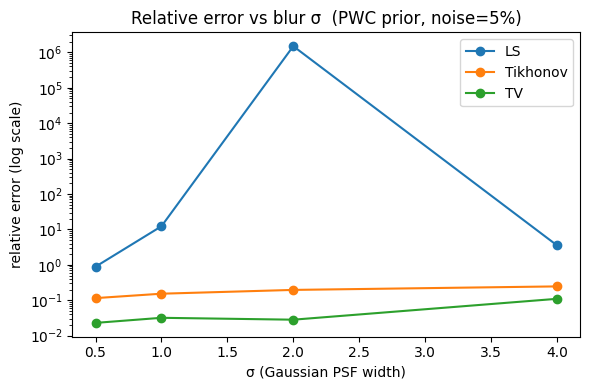

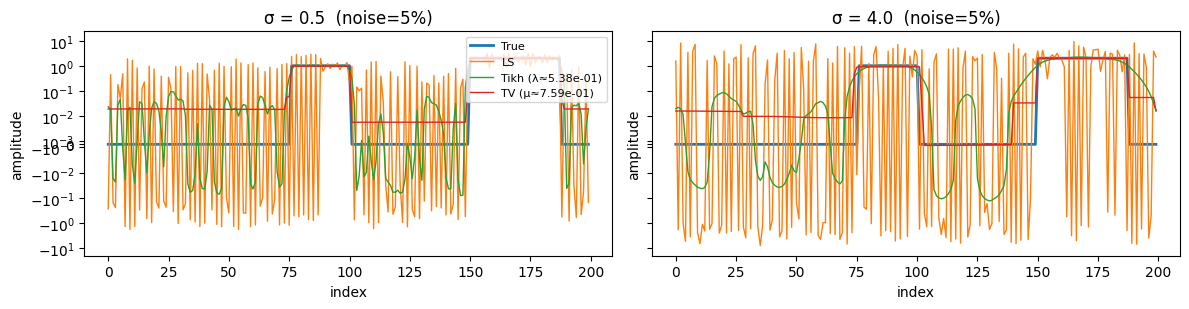

In [69]:
# 2) BLUR SWEEP (fixed noise)
noise_fixed = 0.05
sigmas = [0.5, 1.0, 2.0, 4.0]
print("sigmas =", sigmas)
print("noise_fixed = ", noise_fixed)

# keep identical noise direction across σ for fairness
eta_dir = None
res_blur = []
for s in sigmas:
    r = solve_once_morozov(make_A_zero(n, s), f_true, L_D1, noise_fixed, tau=tau, want_tv=True, eta_dir=eta_dir)
    if eta_dir is None:
        eta_dir = r["eta"]
    res_blur.append(r)

# --- Errors vs blur (shows ill-posedness ↑ with σ; LS unusable; Tikh oversmooths more) ---

fig, ax = plt.subplots(figsize=(6,4))

errs_ls   = np.array([r["err_ls"]  for r in res_blur], dtype=float)
errs_tikh = np.array([r["err_tik"] for r in res_blur], dtype=float)
errs_tv   = (np.array([r["err_tv"] for r in res_blur], dtype=float)
             if "err_tv" in res_blur[0] else None)

eps = 1e-16  # avoids log(0) if any error underflows to 0

ax.plot(sigmas, errs_ls + eps,   marker="o", label="LS")
ax.plot(sigmas, errs_tikh + eps, marker="o", label="Tikhonov")
if errs_tv is not None:
    ax.plot(sigmas, errs_tv + eps, marker="o", label="TV")

ax.set_yscale("log")
ax.set_title(f"Relative error vs blur σ  (PWC prior, noise={noise_fixed:.0%})")
ax.set_xlabel("σ (Gaussian PSF width)")
ax.set_ylabel("relative error (log scale)")
ax.legend()
plt.tight_layout();
plt.show()


# # --- Reconstructions: mild vs heavy blur (edge preservation vs over-smoothing) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3.2), sharey=True)

for ax, s, r in zip(axes, [sigmas[0], sigmas[-1]], [res_blur[0], res_blur[-1]]):
    ax.plot(x, f_true, lw=2, label="True")
    ax.plot(x, r["f_ls"],  lw=1, label="LS")
    ax.plot(x, r["f_tik"], lw=1, label=f"Tikh (λ≈{r['lam']:.2e})")
    if "f_tv" in r:
        ax.plot(x, r["f_tv"], lw=1, label=f"TV (μ≈{r['mu']:.2e})")
    ax.set_title(f"σ = {s:.1f}  (noise={noise_fixed:.0%})")
    ax.set_xlabel("index"); ax.set_ylabel("amplitude")

    # --- symlog so negatives are allowed ---
    curves = [f_true, r["f_ls"], r["f_tik"]] + ([r["f_tv"]] if "f_tv" in r else [])
    max_amp = max(np.max(np.abs(c)) for c in curves)
    linthresh = 1e-3 * (max_amp + 1e-12)   # linear region around 0
    ax.set_yscale("symlog", linthresh=linthresh)
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())  # cleaner minor ticks

axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout();
plt.show()

**Sources for regularization inspiration:**


- L. Ding, L. Li, W. Han, and W. Wang, On existence of a variational regularization parameter under Morozov’s discrepancy principle, arXiv:2506.11397 (math.NA), 2025, version 1.
- P. C. Hansen, Discrete Inverse Problems: Insight and Algorithms, SIAM, Philadelphia, 2010, Chap. 5, pp. 85–105.
- Y.-W. Wen and R. H. Chan, “Parameter selection for total-variation-based image restoration using discrepancy principle,” IEEE Trans. Image Process. 21 (2012), no. 4, 1770–1781. DOI: 10.1109/TIP.2011.2181401.

**Response:** 
- **Regularization Parameters**: I tried to challange myself and used Morozov’s discrepancy principle rather than the suggested L-curve or trial-and-error method. Because I generated the noise and know the noise level, so I set a target residual and chose the regularization parameter $\alpha$ to satisfy $\|A f_\lambda - g_{\mathrm{noisy}}\|_2^2 \approx \|e\|_2^2,$ with a small safety factor $\tau \in [1.0, 1.2]$, hence $\|A f_\lambda - g_{\mathrm{noisy}}\|_2^2 \approx \tau\,\|e\|_2^2$ . I computed $\lambda$ (and $\mu$ for TV/$\ell_1$) via a log-bisection search. In comparison, the L-curve requires a grid of solves (computationally expensive) and its corner can be ambiguous, while trial-and-error is subjective and can over or under-regularize.
- The Hansen et al. textbook also brings GCV and NCP as potential methods, but they would also not be the most efficient methods. GCV assumes a linear estimator and undersmooths for nonlinear TV/ℓ1. NCP assumes a white residual and low-frequency noise can be mistaken as signal and undersmooths.
- I did some further digging and found a paper by L. Ding et al. (2025) goes even one step further and proves that one can select $\alpha$ to keep the residual within a modified Morozov band, establishing existence and covergance for nonlinear inverse problems.

**Observations:**
- With Gaussian blur, the forward operator A is extremely ill-conditioned (as seen in the double check and graphs), so unregularized least squares amplifies noise and fails. 
- Tikhonov regularization stabilizes the inversion but smooths edges and leaves small ripples. The bias grows as noise or blur increase, so the optimal $\lambda$ must increase accordingly.
- For the piecewise-constant signal, TV (ℓ1 on 1st differences) matches the prior and gives the best recoveries (as seen in above).
- In conclusion, when noise increase, LS error explodes, Tikhonov's error grows gradually, and TV stays robust up to a higher threshold. On the other hand, if blur increases, the problem becomes more ill-posed. LS is unusable, Tikhonov oversmooths more, and TV still preserves edges. 

## Problem 2: Fourier Data ##

## Problem 2(a): Calculate Fourier Coefficients $\hat f(k)$ as a function of $k$ ##

$$
f(t)=
\begin{cases}
1, & -\tfrac14 < t \le 0,\\[2pt]
2, & \tfrac12 \le t \le \tfrac78,\\[2pt]
0, & \text{else.}
\end{cases}
$$

**Definition (Fourier coefficients with basis $e^{ik\pi t})$:**
$$
\hat f(k) \;=\; \frac{1}{2}\int_{-1}^{1} f(t)\,e^{-ik\pi t}\,dt.
$$

Only integrate where $f\neq 0$, for $ I_1 = (-\tfrac{1}{4}, 0], \quad I_2 = [\tfrac{1}{2}, \tfrac{7}{8}] $:
$$
\hat f(k)=\frac12\!\left(\int_{-1/4}^{0} e^{-ik\pi t}\,dt \;+\; 2\int_{1/2}^{7/8} e^{-ik\pi t}\,dt\right)
$$


**DC term \(k=0\)**
$$
\hat f(0)=\frac12\int_{-1}^{1} f(t)\,dt
=\frac12\Big(\underbrace{\tfrac14}_{I_1}\cdot 1 + \underbrace{\tfrac38}_{I_2}\cdot 2\Big)
=\frac12\Big(\tfrac14+\tfrac34\Big)=\boxed{\tfrac12}
$$


**Oscillatory terms $k\neq 0$**

Use the antiderivative 

$$
\int e^{-ik\pi t}\,dt=\frac{e^{-ik\pi t}}{-ik\pi}
$$


**First interval $I_1=(-\tfrac14,0]$:**
$$
\int_{-1/4}^{0} e^{-ik\pi t}\,dt
=\left.\frac{e^{-ik\pi t}}{-ik\pi}\right|_{-1/4}^{0}
=\frac{1-e^{ik\pi/4}}{-ik\pi}
$$

**Second interval $I_2=[\tfrac12,\tfrac78]$**:
$$
2\int_{1/2}^{7/8} e^{-ik\pi t}\,dt
=2\left.\frac{e^{-ik\pi t}}{-ik\pi}\right|_{1/2}^{7/8}
=\frac{2\,(e^{-ik\,7\pi/8}-e^{-ik\,\pi/2})}{-ik\pi}
$$

Combine and include the leading factor $\tfrac12$:
$$
\hat f(k)=\frac12\left[
\frac{1-e^{ik\pi/4}}{-ik\pi}
+\frac{2\,(e^{-ik\,7\pi/8}-e^{-ik\,\pi/2})}{-ik\pi}
\right]
$$

Clean the sign by factoring $\frac{1}{-ik\pi}$
:
$$
{\;
\hat f(k)=\frac{1}{2ik\pi}\Big[e^{ik\pi/4}-1 \;+\; 2\big(e^{-ik\pi/2}-e^{-ik\,7\pi/8}\big)\Big],\quad (k\neq 0);}
$$



### Final result
$$
\boxed{\;
\hat f(0)=\tfrac12,\qquad
\hat f(k)=\frac{1}{2ik\pi}\Big[e^{ik\pi/4}-1 + 2\big(e^{-ik\pi/2}-e^{-ik\,7\pi/8}\big)\Big]\;\;,\quad(k\neq 0)
\;}
$$


In [74]:
# 2(a) Fourier Coefficients
ks_test = np.arange(-6, 7)

# Test case
print("k:", ks_test)
print("hat f(k):", np.round(piecewise_const_hat_k(ks_test), 4))

k: [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
hat f(k): [-0.064 -0.0421j -0.0274-0.0787j -0.0796+0.j      0.2416-0.05j
 -0.033 -0.3513j -0.084 +0.2475j  0.5   +0.j     -0.084 -0.2475j
 -0.033 +0.3513j  0.2416+0.05j   -0.0796-0.j     -0.0274+0.0787j
 -0.064 +0.0421j]


## Problem 2(b)

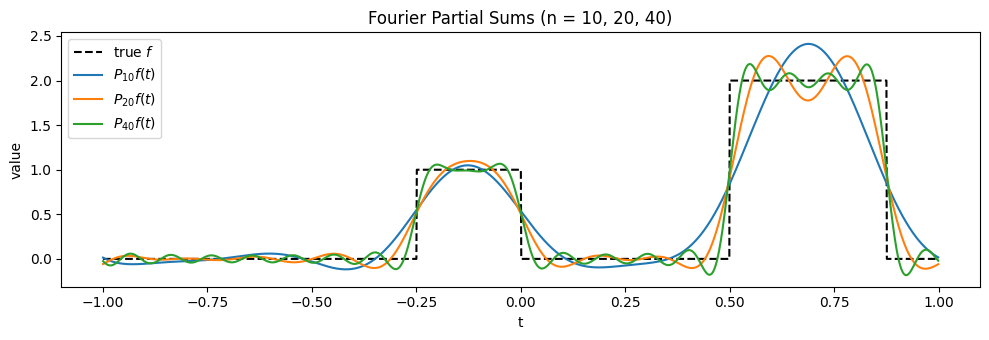

In [76]:
#2(b) Forrier Partial Sum
# fine grid for plotting
t_fine = np.linspace(-1, 1, n*10, endpoint=False)
f_true = signal_piecewise_constant(n=len(t_fine))

# Compute P_n for n=10,20,40
nlist = [10, 20, 40]
Pn_vals = {ns: np.real(fourier_partial_sum(ns, t_fine)) for ns in nlist}

# Plotting
plt.figure(figsize=(10, 3.5))
plt.plot(t_fine, f_true, 'k--', lw=1.5, label='true $f$')
for ns in nlist:
    plt.plot(t_fine, Pn_vals[ns], label=fr"$P_{{{ns}}}f(t)$")
plt.title("Fourier Partial Sums (n = 10, 20, 40)")
plt.xlabel("t"); 
plt.ylabel("value")
plt.legend();
plt.tight_layout();
plt.show()

**Response:** As n increases from 10 to 40, the Fourier partial sums track the flat plateaus of the true piecewise-constant f(t) more accurately and the transition zones become steeper, while the oscillations localize closer to the jump points.

## Problem 2(c)

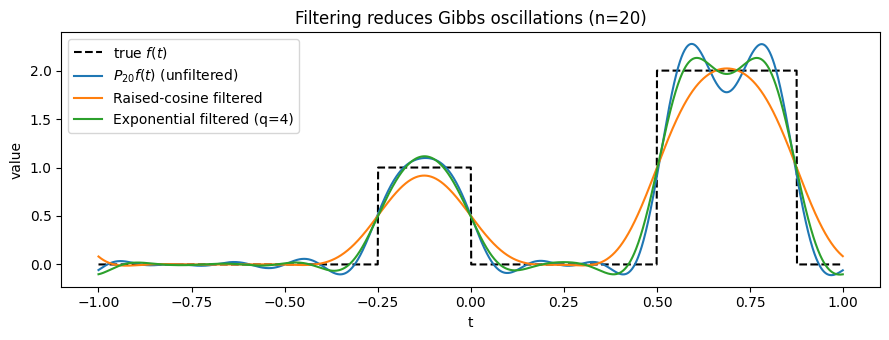

In [79]:
#2(c) Raised Cosine Filter and Exponential Filter
# n = 20 setup
n0 = 20
ks = np.arange(-n0//2, n0//2 + 1)
fhat20 = piecewise_const_hat_k(ks)

# unfiltered P_20
P20 = np.sum(fhat20[:, None] * np.exp(1j * ks[:, None] * np.pi * t_fine[None, :]), axis=0)

# filters
sigma_rc = raised_cosine_filter(ks, N=n0//2)
sigma_exp = exponential_filter(ks, N=n0//2, q=4)

P20_rc  = np.sum((sigma_rc  * fhat20)[:, None] * np.exp(1j * ks[:, None] * np.pi * t_fine[None, :]), axis=0)
P20_exp = np.sum((sigma_exp * fhat20)[:, None] * np.exp(1j * ks[:, None] * np.pi * t_fine[None, :]), axis=0)

plt.figure(figsize=(9, 3.5))
plt.plot(t_fine, f_true, 'k--', lw=1.5, label='true $f(t)$')
plt.plot(t_fine, np.real(P20), label="$P_{20} f(t)$ (unfiltered)")
plt.plot(t_fine, np.real(P20_rc), label="Raised-cosine filtered")
plt.plot(t_fine, np.real(P20_exp), label="Exponential filtered (q=4)")
plt.title("Filtering reduces Gibbs oscillations (n=20)")
plt.xlabel("t");
plt.ylabel("value")
plt.legend();
plt.tight_layout();
plt.show()

**Response:** Raised-cosine gives the least ringing but more smoothing bias. Exponential offers a balanced compromise, less oscillations than unfiltered with better approximations on flat regions than raised-cosine.

## Problem 3: Inverse Method Approach for Fourier Data

In [82]:
# print(n)

noise std = 0.2
TV μ* (discrepancy) = 0.143


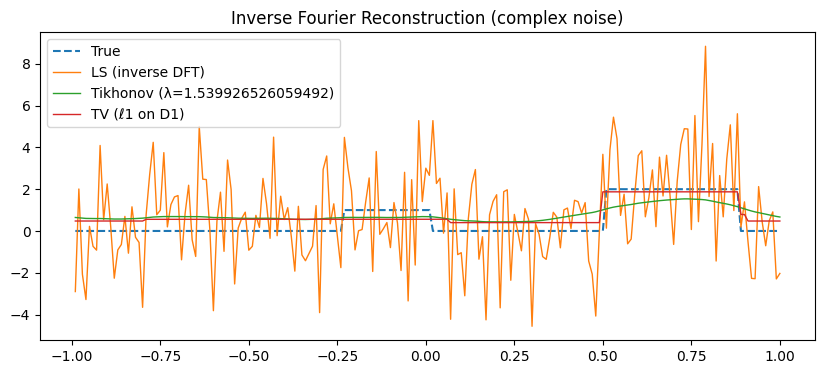

In [102]:
# Assigned new n variable
f_true = signal_piecewise_constant(n)
F, tgrid = dft_matrix_assignment(n)

# Noiseless coefficients and noisy data
eta = 0.2  # noise std
b_clean = F @ f_true
b_noisy, e = add_complex_noise(b_clean, eta=eta)
print("noise std =", eta)

# Least-squares (complex)
f_ls = npl.lstsq(F, b_noisy, rcond=None)[0]

# Tikhonov (complex), L = D1
L = diff_matrix_first(n)

# lam_star = 0.1
target_resid = np.linalg.norm(e) if 'e' in globals() else (len(b_noisy)**0.5) * eta
lam_star, f_tik = pick_lambda_discrepancy_bisect(F, L, b_noisy, target_resid)

# TV / ℓ1 in complex
mu_tv, f_tv = pick_mu_discrepancy_bisect(F, L, b_noisy, target_resid)
print(f"TV μ* (discrepancy) = {mu_tv:.3g}")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(tgrid, f_true, lw=1.5, linestyle='--', label='True')
ax.plot(tgrid, np.real(f_ls), lw=1, label='LS (inverse DFT)')
ax.plot(tgrid, np.real(f_tik), lw=1, label=f'Tikhonov (λ={lam_star})')
ax.plot(tgrid, np.real(f_tv), lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Inverse Fourier Reconstruction (complex noise)")
ax.legend();
plt.show();

**Response:** The plot show a bias-variance trade off for the Inverse-Fourier problem with complex noise. LS is too noisy. Tikhonov suppresses most noise but rounds the jump and depresses the pleteaus. Therefore, TV is the best match to the true piecewise constant function. 

## Problem 4: Saw Tooth Function with Periodic Blur and Fourier Inversion ##

In [106]:
# print(n)

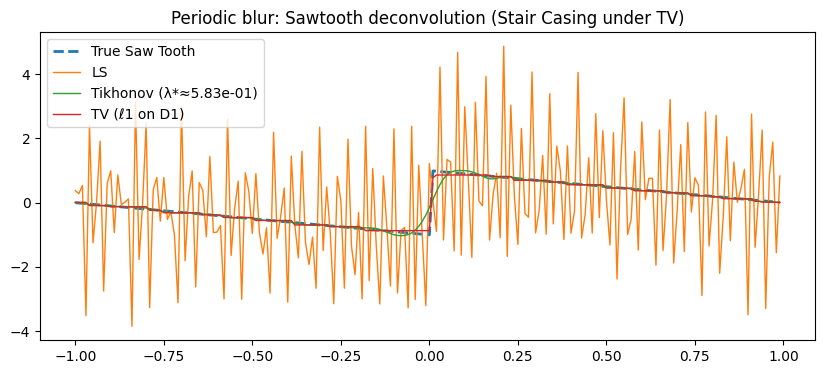

In [108]:
f_saw = signal_sawtooth(n)
psf = gaussian_psf_from_m_sigma(m=6, sigma=2.5)

# Periodic blur case
A_per = blur_matrix_periodic(psf, n)
g_clean = A_per @ f_saw
g_noisy, e = add_relative_noise(g_clean, rel=0.05)

# LS (deconvolution)
f_ls_saw = solve_ls(A_per, g_noisy)

# Tikhonov (L = D1)
target_resid = np.linalg.norm(e)
lam_star, f_tik_saw = pick_lambda_discrepancy_bisect(A_per, L, g_noisy, target_resid)

# TV (ℓ1 on D1) — staircasing expected
mu_tv, f_tv_saw = pick_mu_discrepancy_bisect(A_per, L, g_noisy, target_resid)

# Plot periodic blur recon
t = -1 + 2*np.arange(n)/n
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t, f_saw, lw=2, linestyle='--', label='True Saw Tooth')
ax.plot(t, f_ls_saw, lw=1, label='LS')
ax.plot(t, f_tik_saw, lw=1, label=f'Tikhonov (λ*≈{lam_star:.2e})')
if _HAS_CVXPY:
    ax.plot(t, f_tv_saw, lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Periodic blur: Sawtooth deconvolution (Stair Casing under TV)")
ax.legend();
plt.show();

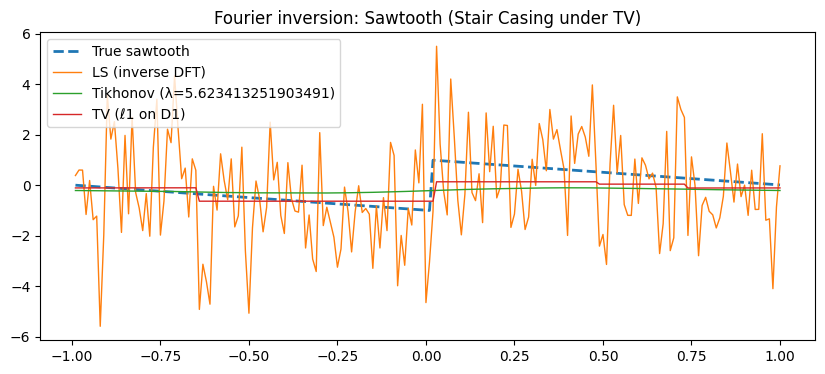

In [110]:
# Fourier inversion for saw tooth
F, tgrid = dft_matrix_assignment(n)
b_clean = F @ f_saw
b_noisy, e_saw = add_complex_noise(b_clean, eta=eta)

# LS
f_ls_F = npl.lstsq(F, b_noisy, rcond=None)[0]

# Tikhonov
L = diff_matrix_first(n)
target_resid = npl.norm(e_saw)
lam_star_F, f_tik_F = pick_lambda_discrepancy_bisect(F, L, b_noisy, target_resid)

# TV
mu_star_F, f_tv_F = pick_mu_discrepancy_bisect(F, L, b_noisy, target_resid)

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(tgrid, f_saw, lw=2, linestyle='--', label='True sawtooth')
ax.plot(tgrid, np.real(f_ls_F), lw=1, label='LS (inverse DFT)')
ax.plot(tgrid, np.real(f_tik_F), lw=1, label=f'Tikhonov (λ={lam_star_F})')
if _HAS_CVXPY:
    ax.plot(tgrid, np.real(f_tv_F), lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Fourier inversion: Sawtooth (Stair Casing under TV)")
ax.legend();
plt.show();

**Response:** We can observe the stair casing effect in the TV (ℓ1) regularization case at $t\approx 0$ in the periodic blur case more mildly in the Fourier inversion.